# Chat bot test with tensorflow seq2seq model 

## getting started


Code is an modification of the tensorflow seq2seq tutorial that can be found [here](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention).

Paper on seq2seq modeling can be found (here)[https://arxiv.org/pdf/1409.3215.pdf]

Nice blogpost on [seq2seq](http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)

To train the chatbot, dialogs are considered as follows: line 1 is a 'question', then line 2 is an 'answer', line 3 is a 'question', line 4 is an 'answer', etc....

In [1]:
import pickle
import time
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from sklearn.model_selection import train_test_split

import tweede_kamer_TF_chatbot as tk
from tweede_kamer_TF_chatbot import Encoder ,Decoder, BahdanauAttention, train_step, evaluate

## Preprocess function

we need lists of pairs with start end, like the exmaple below

In [7]:
pairs_ = [
    [
        'jackie exhales what the hell was that for ? ',
        'shall i call security or do you think'
    ],
    [
        'you can control yourself ? stephanie are you proud',
        'of yourself stealing from us ?'
    ],
    [
        'jackie was something stolen ? stephanie was something',
        'stolen ? oh don t you pretend with me.'
    ]
]
pairs = [[tk.preprocess_sentence(w) for w in pair]  for pair in pairs_]
pairs

[['<start> jackie exhales what the hell was that for ? <end>',
  '<start> shall i call security or do you think <end>'],
 ['<start> you can control yourself ? stephanie are you proud <end>',
  '<start> of yourself stealing from us ? <end>'],
 ['<start> jackie was something stolen ? stephanie was something <end>',
  '<start> stolen ? oh don t you pretend with me . <end>']]

In [2]:
# for example the bold and the beautifull examples
# pairs_ = pickle.load( open( "TheBoldPairs.pck", "rb" ) )
# pairs = [[tk.preprocess_sentence(w) for w in pair]  for pair in pairs_]

## import kamer speeches

In [2]:
## put data chuncks in one zip file
#!cat data/CorpusTweedeKamer* > CorpusTweedeKamer.zip

In [3]:
%%time
tweede_kamer = pd.read_csv("CorpusTweedeKamer.zip")
tweede_kamer = (
    tweede_kamer
    .assign(datum = pd.to_datetime(tweede_kamer.date))
    .assign(speaker = tweede_kamer.speaker.str.lower())
)

CPU times: user 13.1 s, sys: 959 ms, total: 14 s
Wall time: 14.3 s


In [4]:
tweede_kamer.shape

(1143366, 12)

In [5]:
recente_speeches = (
    tweede_kamer
    .dropna(subset = ["text"])
    .query('terms < 600')
    .query('datum >= "2019-05-01"')
)

In [7]:
recente_speeches.shape

(13731, 12)

## Prep speeches in the right format for chatbot training.

In [8]:
speeches = recente_speeches.text.str.lower().values.tolist()

In [9]:
### TAKE FIRST NSPEECHES
NSPEECHES = int(1000)
half = int(NSPEECHES/2)

#### trunccate speeches because otherwise they are too long for training

In [22]:
speeches_truncated = [s[0:200] for s in speeches]

In [24]:
tmp = np.array(speeches_truncated[0:NSPEECHES]).reshape(half,2)

In [25]:
pairs_ = tmp.tolist()
pairs = [[tk.preprocess_sentence(w) for w in pair]  for pair in pairs_]

## Pre processing of lists into tensors

In [27]:
input_tensor, target_tensor, inp_lang, targ_lang = tk.load_dataset(pairs)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = tk.max_length(target_tensor), tk.max_length(input_tensor)
print(max_length_targ, max_length_inp )

52 49


In [28]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

400 400 100 100


In [29]:
print ("Input Language; index to word mapping")
tk.convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
tk.convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
3 ----> <start>
73 ----> ja
5 ----> ,
7 ----> ik
37 ----> heb
8 ----> dat
240 ----> samen
27 ----> met
116 ----> collega
618 ----> schouten
12 ----> in
11 ----> een
139 ----> brief
33 ----> over
11 ----> een
107 ----> aantal
1033 ----> bedreigde
1034 ----> konijnenfokkers
20 ----> ook
205 ----> aangegeven
1 ----> .
8 ----> dat
10 ----> is
121 ----> precies
6 ----> het
175 ----> punt
8 ----> dat
49 ----> mevrouw
633 ----> laan
1035 ----> aanhaalt
1 ----> .
7 ----> ik
37 ----> heb
103 ----> gezegd
160 ----> wilt
17 ----> u
1036 ----> alstublieft
1037 ----> aa
4 ----> <end>

Target Language; index to word mapping
3 ----> <start>
35 ----> dank
26 ----> u
23 ----> wel
5 ----> ,
39 ----> voorzitter
1 ----> .
2 ----> de
22 ----> minister
455 ----> refereerde
19 ----> aan
11 ----> een
144 ----> aantal
618 ----> gesprekken
8 ----> dat
82 ----> hij
2 ----> de
245 ----> afgelopen
254 ----> maanden
36 ----> heeft
619 ----> gehouden
1 ----> .
42 ----> wat
10 --

In [30]:
BUFFER_SIZE     = len(input_tensor_train)
BATCH_SIZE      = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim   = 256
units           = 1024
vocab_inp_size  = len(inp_lang.word_index)+1
vocab_tar_size  = len(targ_lang.word_index)+1

dataset         = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset         = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [31]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 49]), TensorShape([64, 52]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

## define the encoder, attention and decoder classes

In [32]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 49, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [33]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 49, 1)


In [34]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(
    tf.random.uniform((64, 1)),
    sample_hidden, 
    sample_output
)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2053)


## Optimizer

In [35]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    reduction = 'none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    optimizer = optimizer,
    encoder = encoder,
    decoder = decoder
)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [37]:
%%time 

EPOCHS = 5
losses = []

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden, encoder, decoder, targ_lang, BATCH_SIZE,loss_function, optimizer)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  
  losses.append(total_loss / steps_per_epoch)

Epoch 1 Batch 0 Loss 4.3085
Epoch 1 Loss 3.9136
Time taken for 1 epoch 189.72013592720032 sec

Epoch 2 Batch 0 Loss 2.6602
Epoch 2 Loss 3.2681
Time taken for 1 epoch 73.46453595161438 sec

Epoch 3 Batch 0 Loss 3.0542
Epoch 3 Loss 3.1601
Time taken for 1 epoch 67.29420804977417 sec

Epoch 4 Batch 0 Loss 2.7955
Epoch 4 Loss 3.0720
Time taken for 1 epoch 67.09653878211975 sec

Epoch 5 Batch 0 Loss 3.0104
Epoch 5 Loss 3.0479
Time taken for 1 epoch 65.42424607276917 sec



<Figure size 432x288 with 0 Axes>

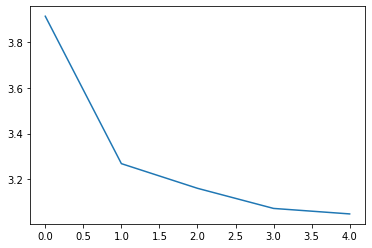

In [38]:
plt.figure()
fig, ax = plt.subplots()
plt.plot(losses)

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [39]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [40]:
def translate(sentence, max_length_targ, max_length_inp, units, encoder, decoder, inp_lang, targ_lang, plot = False):
    result, sentence, attention_plot = evaluate(sentence, max_length_targ, max_length_inp, units, encoder, decoder, inp_lang, targ_lang)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    if plot:
      plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [17]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [44]:
translate(u'mevrouw wanneer is het tijd', max_length_targ, max_length_inp, units, encoder, decoder, inp_lang, targ_lang)

Input: <start> mevrouw wanneer is het tijd <end>
Predicted translation: de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de 
